In [1]:
import os
import warnings


In [2]:
# os.environ["PYTHONWARNINGS"]="ignore"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"
warnings.filterwarnings("ignore")
# os.environ

In [3]:

import glob

import numpy as np
# from ray.tune.search.hyperopt import HyperOptSearch
import optuna
import pandas as pd
import torch
from IPython.display import display
from neuralforecast.auto import AutoLSTM, AutoNBEATS, AutoNHITS, AutoPatchTST
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.numpy import mae, mse
from neuralforecast.losses.pytorch import MSE
from ray import tune
from statsforecast import StatsForecast

from utils.utils import build_market_image

# optuna.logging.set_verbosity(optuna.logging.WARNING) # Use this to disable training prints from optuna

2024-06-28 18:50:36,948	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-28 18:50:37,123	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
COIN_PAIRS=['BTC/USDT','ETH/USDT','SOL/USDT','BNB/USDT','XRP/USDT','ADA/USDT',
            'ETH/BTC','SOL/ETH','BNB/ETH','XRP/ETH',"ADA/ETH",
            'SOL/BTC','SOL/BNB',
            'XRP/BTC','XRP/BNB',
            'ADA/BTC','ADA/BNB',
            ]
target_pair='EUR_USD'
time_frame="1h"

In [5]:
data=build_market_image(target_pair='EUR_USD',time_frame='1h',axis=0,dir='data_forex')

data=data.reset_index(level=0,drop=True).reset_index()
id_columns=['symbol']


In [6]:
front=['y','ds','symbol']
data=data[front+[c for c in data.columns if c not in front]]
data=data[front]

In [7]:
data

,y,ds,symbol
0,0.72673,2022-01-02 22:00:00,AUD_USD
1,0.72678,2022-01-02 23:00:00,AUD_USD
2,0.72656,2022-01-03 00:00:00,AUD_USD
3,0.72558,2022-01-03 01:00:00,AUD_USD
4,0.72525,2022-01-03 02:00:00,AUD_USD
...,...,...,...
99392,16.93428,2023-12-29 17:00:00,USD_MXN
99393,16.93203,2023-12-29 18:00:00,USD_MXN
99394,16.96690,2023-12-29 19:00:00,USD_MXN
99395,16.97930,2023-12-29 20:00:00,USD_MXN


In [8]:
eth_data=data[data['symbol']==target_pair].copy()
split=int(len(eth_data)*.7)
print(split)
train=data.groupby('symbol').head(split)
test=data.groupby('symbol').tail(split)



8698


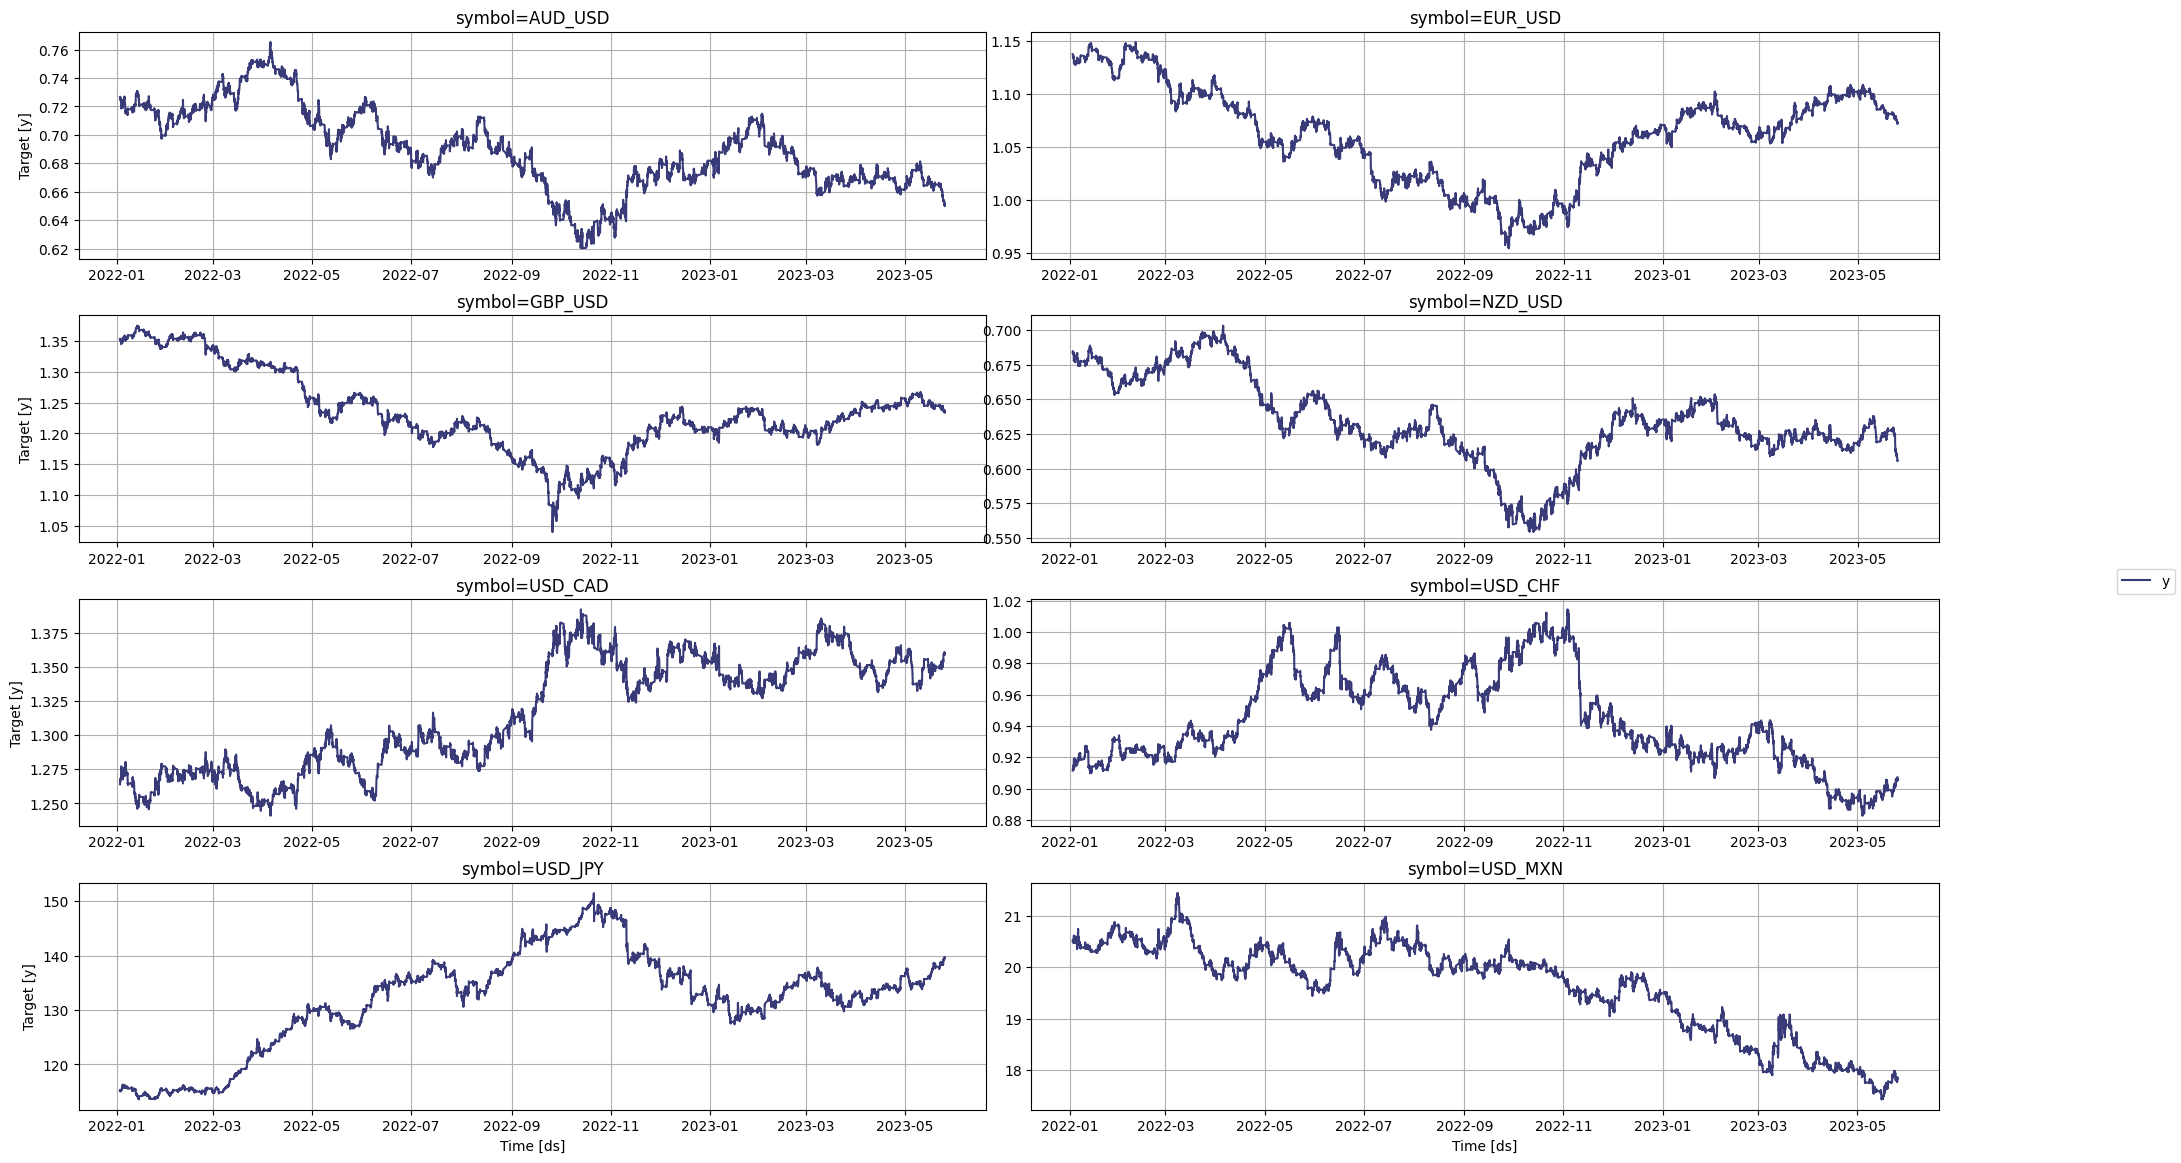

In [9]:
StatsForecast.plot(train,id_col='symbol', engine='matplotlib')

In [10]:
search_space={

    "loss":MSE(),

    "input_size": tune.choice([12, 24, 48, 64]),              # Length of input window
    "start_padding_enabled": True,
    "n_blocks": 5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],         
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),
                                                              # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-6, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None]),                             # Scaler type
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([128, 256, 512]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}


In [11]:
forecast_horizon=6
backend='optuna'
PatchTST_config=AutoPatchTST.get_default_config(h=forecast_horizon,backend='ray')
NHITS_config=AutoNHITS.get_default_config(h=forecast_horizon,backend='ray')
NBEATS_config=AutoNBEATS.get_default_config(h=forecast_horizon,backend='ray')
PatchTST_config

{'h': None,
 'hidden_size': <ray.tune.search.sample.Categorical at 0x286920c40>,
 'n_heads': <ray.tune.search.sample.Categorical at 0x286920cd0>,
 'patch_len': <ray.tune.search.sample.Categorical at 0x286920d60>,
 'learning_rate': <ray.tune.search.sample.Float at 0x286920df0>,
 'scaler_type': <ray.tune.search.sample.Categorical at 0x286920eb0>,
 'revin': <ray.tune.search.sample.Categorical at 0x286920f40>,
 'max_steps': <ray.tune.search.sample.Categorical at 0x286920fd0>,
 'batch_size': <ray.tune.search.sample.Categorical at 0x286921060>,
 'windows_batch_size': <ray.tune.search.sample.Categorical at 0x2869210f0>,
 'loss': None,
 'random_seed': <ray.tune.search.sample.Integer at 0x286921180>,
 'input_size': <ray.tune.search.sample.Categorical at 0x2b839b7c0>,
 'step_size': <ray.tune.search.sample.Categorical at 0x2b839a980>}

In [12]:
keys=set.intersection(*[set(PatchTST_config.keys()),set(NBEATS_config.keys()),list(NHITS_config.keys())])
keys

{'batch_size',
 'h',
 'input_size',
 'learning_rate',
 'loss',
 'max_steps',
 'random_seed',
 'scaler_type',
 'step_size',
 'windows_batch_size'}

In [13]:
def config_patchTST(trial):

    auto_config=AutoPatchTST.get_default_config(h=forecast_horizon,backend='optuna')

    config = {**auto_config(trial)}
    config.update({
                    "enable_progress_bar":False,
                    "max_steps":5000
                   })
    return config

def config_nhits(trial):
    auto_config=AutoNHITS.get_default_config(h=forecast_horizon,backend='optuna')

    config = {**auto_config(trial)}
    config.update({
                    "enable_progress_bar":False,
                    "max_steps":5000
                   })
    return config

def config_nbeats(trial):
    auto_config=AutoNBEATS.get_default_config(h=forecast_horizon,backend='optuna')
    config = {**auto_config(trial)}
    config.update({
                    "enable_progress_bar":False,
                    "max_steps":5000
                   })
    return config

def config_lstm(trial):
    auto_config=AutoLSTM.get_default_config(h=forecast_horizon,backend='optuna')
    config = {**auto_config(trial)}
    config.update({
                    "enable_progress_bar":False,
                    "max_steps":5000
                   })
    return config

In [14]:
PatchTST_config.update({x:y for x,y in search_space.items() if x in PatchTST_config})
NHITS_config.update({x:y for x,y in search_space.items() if x in NHITS_config})
NBEATS_config.update({x:y for x,y in search_space.items() if x in NBEATS_config})
PatchTST_config

{'h': None,
 'hidden_size': <ray.tune.search.sample.Categorical at 0x286920c40>,
 'n_heads': <ray.tune.search.sample.Categorical at 0x286920cd0>,
 'patch_len': <ray.tune.search.sample.Categorical at 0x286920d60>,
 'learning_rate': <ray.tune.search.sample.Float at 0x2b839a320>,
 'scaler_type': <ray.tune.search.sample.Categorical at 0x2b8399600>,
 'revin': <ray.tune.search.sample.Categorical at 0x286920f40>,
 'max_steps': <ray.tune.search.sample.Categorical at 0x2b8398f40>,
 'batch_size': <ray.tune.search.sample.Categorical at 0x2b839a650>,
 'windows_batch_size': <ray.tune.search.sample.Categorical at 0x2b839a5c0>,
 'loss': MSE(),
 'random_seed': <ray.tune.search.sample.Integer at 0x2b839a530>,
 'input_size': <ray.tune.search.sample.Categorical at 0x2b8398c70>,
 'step_size': <ray.tune.search.sample.Categorical at 0x2b839a980>}

In [15]:
PatchTST_config["input_size"]=tune.choice([12, 24, 48, 64])

In [16]:
horizon = 6
context_length=5*horizon
max_steps=2000
models = [AutoNHITS(
                    h = forecast_horizon,
                    loss = MSE(),
                    num_samples = 30,
                    search_alg = optuna.samplers.TPESampler(),
                    backend = 'optuna',
                    # enable_progress_bar=False,
                    config = config_nhits,
                    ),
         AutoNBEATS(
                    h = forecast_horizon,
                    loss = MSE(),
                    num_samples = 30,
                    search_alg = optuna.samplers.TPESampler(),
                    backend = 'optuna',
                    # enable_progress_bar=False,
                    config=config_nbeats,
                    ),
         AutoPatchTST(
                    h = forecast_horizon,
                    loss = MSE(),
                    num_samples = 30,
                    search_alg = optuna.samplers.TPESampler(),
                    backend = 'optuna',
                    # enable_progress_bar=False,
                    config = config_patchTST),
        AutoLSTM(
                    h = forecast_horizon,
                    loss = MSE(),
                    num_samples = 30,
                    search_alg = optuna.samplers.TPESampler(),
                    backend = 'optuna',
                    
                    # enable_progress_bar=False,
                    config = config_lstm)
          ]

nf = NeuralForecast(models = models,
                     freq = '1h')

In [17]:
mps_device = torch.device("mps")
z = torch.ones(5, device=mps_device)
z

tensor([1., 1., 1., 1., 1.], device='mps:0')

In [18]:
nf.fit(train,
        val_size=horizon,
        time_col='ds',                    
        target_col='y',
        id_col='symbol'
        
        )


[I 2024-06-28 18:50:41,932] A new study created in memory with name: no-name-6b8c46e3-39a4-470e-b7b4-92dff70f3aa0
Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.534     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_steps=5000` reached.
[I 2024-06-28 18:55:29,871] Trial 0 finished with value: 0.0028259707614779472 and parameters: {'n_pool_kernel_size': [2, 2, 2], 'n_freq_downsample': [40, 20, 1], 'learning_rate': 0.0005462966613829039, 'scaler_type

In [19]:
model_path='FX_forecasting_model/'
nf.save(model_path,overwrite=True,save_dataset=False)
# nf.load(model_path)

In [20]:

Y_pred = nf.predict().reset_index()
preds_df=Y_pred
preds_df['mean_pred']=preds_df.filter(like='Auto').mean(1)
preds_df= preds_df.merge(test, how='left', on=['symbol', 'ds'])
preds_df=pd.concat([train.tail(48),preds_df]).reset_index()
preds_df.tail(10)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


,index,y,ds,symbol,AutoNHITS,AutoNBEATS,AutoPatchTST,AutoLSTM,mean_pred
86,38,139.82000,2023-05-25 15:00:00,USD_JPY,139.775208,139.764557,139.719055,139.757233,139.754013
87,39,139.92800,2023-05-25 16:00:00,USD_JPY,139.761490,139.784714,139.721481,139.758926,139.756653
88,40,139.90700,2023-05-25 17:00:00,USD_JPY,139.767670,139.785019,139.723434,139.767120,139.760803
89,41,139.98900,2023-05-25 18:00:00,USD_JPY,139.774796,139.814270,139.725540,139.781738,139.774078
90,42,17.82150,2023-05-25 17:00:00,USD_MXN,17.536160,17.837023,17.835913,17.831495,17.760149
91,43,17.85687,2023-05-25 18:00:00,USD_MXN,17.532150,17.854271,17.838619,17.832615,17.764414
92,44,17.84057,2023-05-25 19:00:00,USD_MXN,17.544163,17.878454,17.840900,17.832193,17.773928
93,45,17.85480,2023-05-25 20:00:00,USD_MXN,17.531008,17.881607,17.844402,17.828983,17.771500
94,46,17.85400,2023-05-25 21:00:00,USD_MXN,17.536940,17.893974,17.845213,17.832996,17.777283
95,47,17.85410,2023-05-25 22:00:00,USD_MXN,17.543766,17.901316,17.846424,17.830938,17.780611


In [25]:
fcst_df = nf.predict(test)
fcst_df['mean_pred']=fcst_df[['AutoNHITS', 'AutoNBEATS','AutoPatchTST']].mean(1)
fcst_df.head()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


,ds,AutoNHITS,AutoNBEATS,AutoPatchTST,AutoLSTM,mean_pred
symbol,,,,,,
AUD_USD,2023-12-29 22:00:00,0.659383,0.681088,0.681002,0.681396,0.673824
AUD_USD,2023-12-29 23:00:00,0.659235,0.681128,0.680989,0.681275,0.673784
AUD_USD,2023-12-30 00:00:00,0.659678,0.680915,0.680901,0.681252,0.673832
AUD_USD,2023-12-30 01:00:00,0.659193,0.680837,0.680807,0.681292,0.673612
AUD_USD,2023-12-30 02:00:00,0.659412,0.680846,0.680770,0.681186,0.673676


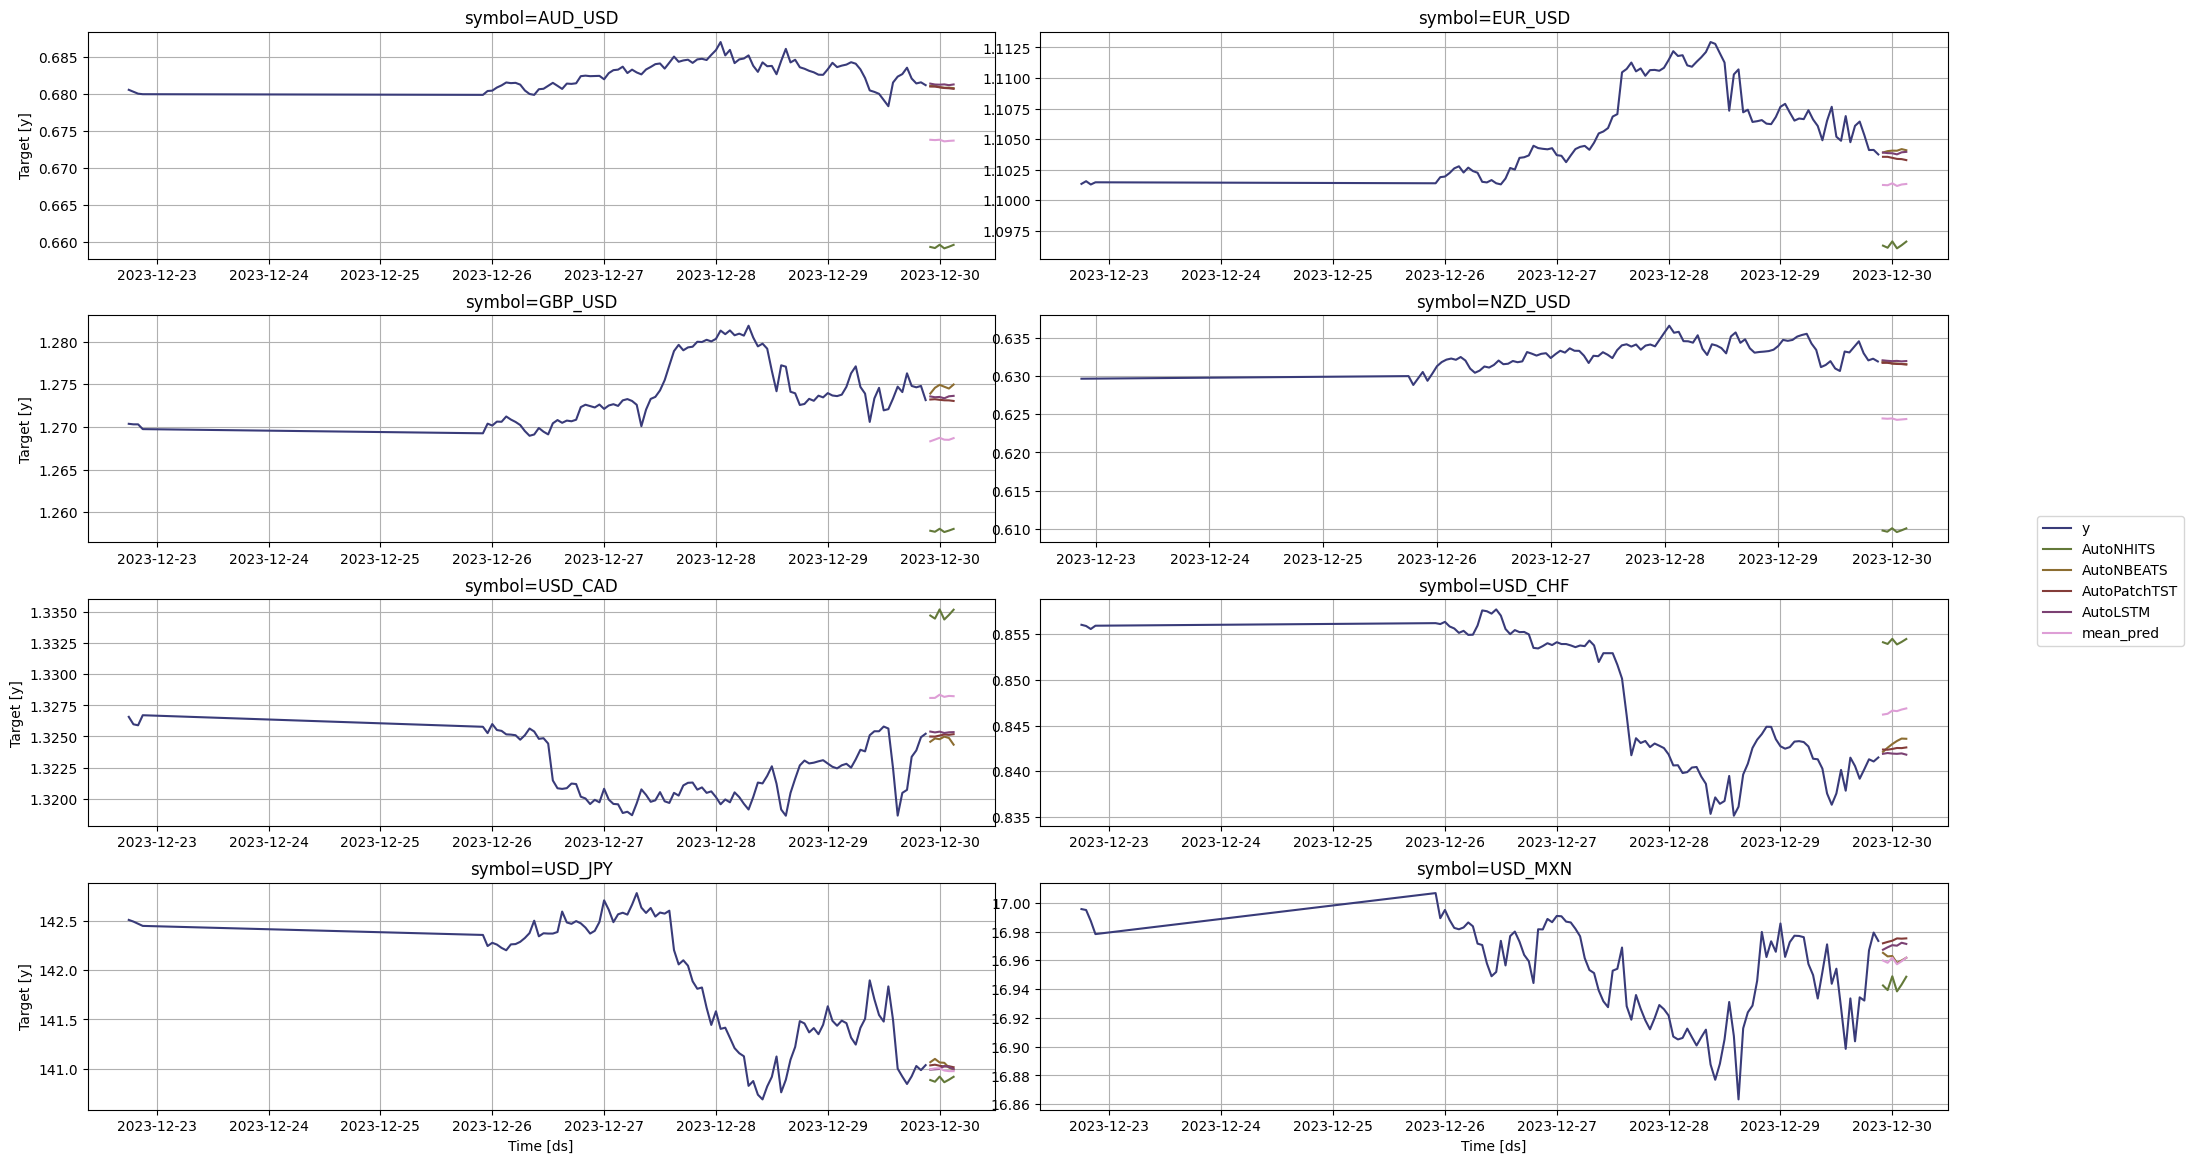

In [26]:
StatsForecast.plot(test, fcst_df, id_col='symbol',engine='matplotlib', max_insample_length=100)

In [23]:
model=nf.models[0]
model

AutoNHITS